In [1]:
# General import of torch.
import torch
# Import for graph blocks of torch.
import torch.nn as nn
# Import the models library, to get the model to be used.
import torchvision.models as models
# Import optim library, to get the optimizer to be used.
import torch.optim as optim
# Import torchvision, to manage the input data.
import torchvision
# To apply transformations to the data (when loaded).
import torchvision.transforms as transforms

# General imports.
import os
import time
import wandb
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

### Enviroment configuration.

In [2]:
# Input size of the model.
inputSize = 'inputSize'
# Output size of the model.
outputSize = 'outputSize'
# Batch size.
batchSize = 'batchSize'
# Epochs amount.
epochs = 'epochs'
# Learning rate.
learningRate = 'learningRate'
# Examples to be showed when requested.
testView = 'testView'
# Class names.
classes = 'classes'
# Number of classes to classify.
classesLen = 'classesLen'

config = {
    inputSize    : 224,
    outputSize   : 4,
    batchSize    : 100,
    epochs       : 50,
    learningRate : 0.001,
    testView     : 8,
    classes      : ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia'],
    classesLen   : 4
}

# Device to be used, prefer cuda, if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Miscellaneous functions.

In [3]:
# About metrics.
# Metric dictionary keys 
_loss            = 'Loss'
_accuracy        = 'Accuracy'
_accuracyClass   = 'Accuracy class'
_groundtruth     = 'Groundtruth'
_predictions     = 'Predictions'
_confusionMatrix = 'Confusion matrix'
# For torch save
_model           = 'Model State Dic'
_optimizer       = 'Optimizer State Dic'
_epoch           = 'Epoch'
_metricsTrain    = 'Resulting metrics (training)'
_metricsTest     = 'Resulting metrics (testing)'

# Get a clean dictionary for the metrics.
def getMetricsDict():
    return {
        _loss            : torch.tensor(0.),
        _accuracy        : torch.tensor(0.),
        _accuracyClass   : torch.zeros(config[classesLen]),
        _groundtruth     : torch.tensor([]),
        _predictions     : torch.tensor([]),
        _confusionMatrix : torch.zeros((config[classesLen], config[classesLen]), dtype=torch.int)
    }

# Function used to update the dictionary of resulting metrics.
def updateRunningMetrics(outputs, groundtruth, loss, batchAmount, metricsResults):
    # Accumulate the loss.
    metricsResults[_loss] += loss.cpu() / batchAmount
    # Accumulate the groundtruth and the predictions.
    metricsResults[_groundtruth] = torch.cat((metricsResults[_groundtruth], groundtruth.cpu())) 
    metricsResults[_predictions] = torch.cat((metricsResults[_predictions], outputs.cpu()))
    # Accumulate the confusion matrix.
    confusionMatrix = getConfusionMatrix(outputs, groundtruth)
    metricsResults[_confusionMatrix] += confusionMatrix

# Function used to process the dictionary of resulting metrics (make final calculations).
def processRunningMetrics(metricsResults):
    # Get the total of samples processed by class.
    classTotal = torch.sum(metricsResults[_confusionMatrix], 1)
    # Get the total of samples correctly classified by class.
    classCorrect = torch.diagonal(metricsResults[_confusionMatrix])

    # Get the total accuracy, correct total samples / total samples.
    metricsResults[_accuracy] = torch.sum(classCorrect) / torch.sum(classTotal)
    # Get the total accuracy, by class.
    metricsResults[_accuracyClass] = classCorrect / classTotal

# This functions process an metrics result dictionary for wandb. Is necessary to indicte
#   the metrics origin, training or testing.
def processMetricsWandb(metricsResults, training=False):
    # Get the prefix to log on wandb, the keys must be different.
    resultsType = 'training' if training else 'testing'

    # All the wandb keys are based in the original metrics results keys.
    lossKey = '{} ({})'.format(_loss, resultsType)
    accuracyKey = '{} ({})'.format(_accuracy, resultsType)
    accuracyClassKeys = ['{} accuracy ({})'.format(_class, resultsType) for _class in config[classes]]
    confusionMatrixKey = '{} ({})'.format(_confusionMatrix, resultsType)

    # Get the predictions.
    predictions = torch.argmax(metricsResults[_predictions], axis=1)

    # Get the confusion matrix
    confusionMatrix = wandb.plot.confusion_matrix(y_true=metricsResults[_groundtruth].tolist(),
        preds=predictions.tolist(), class_names=config[classes], title=confusionMatrixKey)

    # Make the dictionary for wandb and store the values.
    wandbDict = {
        lossKey            : metricsResults[_loss].item(),
        accuracyKey        : metricsResults[_accuracy].item(),
        confusionMatrixKey : confusionMatrix
    }
    for i in range(config[classesLen]):
        wandbDict[accuracyClassKeys[i]] = metricsResults[_accuracyClass][i].item()

    # Return, to log later.
    return wandbDict

# Get the metrics dictionaries for wandb and log them.
def logMetricsWandb(trainMetricsResults, testMetricsResults):
    # Get both dictionaries for wandb.
    wandbTrainDict = processMetricsWandb(trainMetricsResults, training=True)
    wandbTestDict  = processMetricsWandb(testMetricsResults, training=False)

    # Merge the dictionaries.
    wandbDict = {**wandbTrainDict, **wandbTestDict}

    # Log on wandb
    wandb.log(wandbDict)

# Pretty print the metrics dictionaries.
def printMetricsDict(metricsResults):
    # Build accuracy by class.
    accuracyClassStr = ''
    for i, _class in enumerate(config[classes]):
        accuracyClassStr += '{}: {:2.2f}%'.format(_class, metricsResults[_accuracyClass][i] * 100)
        accuracyClassStr += ', '
    accuracyClassStr = accuracyClassStr[:-2]

    print('Loss: {:.4f}, Accuracy: {:2.2f}% ({})'.format(metricsResults[_loss], metricsResults[_accuracy] * 100, accuracyClassStr))

# Function used to save the model and the metrics.
def saveEpochData(trainMetricsResults, testMetricsResults, model, optimizer, epoch, rootPath):
    # Create a dir for the current epoch.
    runDir = os.path.join(os.getcwd(), rootPath, str(epoch))
    Path(runDir).mkdir(parents=True, exist_ok=True)

    # Path
    savePath = os.path.join(runDir, 'model.pth')

    # Make dict for torch.save
    saveDict = {
        _model     : model.state_dict(),
        _optimizer : optimizer.state_dict(),
        _epoch     : epoch
    }

    # Save both metrics, for train and test.
    metricsResults = {
        _metricsTrain : trainMetricsResults,
        _metricsTest  : testMetricsResults
    }

    # Merge the save dict with the metricsResults dict.
    saveDict = {**metricsResults, **saveDict}

    # Save
    torch.save(saveDict, savePath)

### Loader function.
Should return the training loader and test loader, a iterable object by batches.

In [4]:
# Transformation definitions.
transformTrain = transforms.Compose([
        transforms.RandomResizedCrop(config[inputSize]),  # This one does a resize (it cuts randomly, it doesn't keep the whole image).
        transforms.RandomHorizontalFlip(),                # Flip the image horizontally randomly.
        transforms.ToTensor(),                            # Make the image a tensor.
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Expected normalization for pretrained pytorch models.
    ])
transformTest = transforms.Compose([
        transforms.Resize(config[inputSize]),             # Resize the image, keeping all pixels.
        transforms.CenterCrop(config[inputSize]),         # Cut the image in the center.
        transforms.ToTensor(),                            # Make the image a tensor.
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Expected normalization for pretrained pytorch models.
    ])

# Function used to get the data loaders.
# A folder with two folders inside called train and test is expected as a rootPath.
def getLoaders(rootPath):
    trainPath = os.path.join(rootPath, 'train')
    testPath  = os.path.join(rootPath, 'test')

    # Get the training and test data, apply the transformations.
    trainset = torchvision.datasets.ImageFolder(root=trainPath, transform=transformTrain)
    testset  = torchvision.datasets.ImageFolder(root=testPath,  transform=transformTest)

    # Get the loaders, to iterate the data through batches.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config[batchSize], shuffle=True, num_workers=2)
    testloader  = torch.utils.data.DataLoader(testset,  batch_size=config[batchSize], shuffle=True, num_workers=2)

    return trainloader, testloader

### Calculate the confusion matrix.

In [5]:
# Function to get the confusion matrix values.
def getConfusionMatrix(outputs, groundtruth):
    # Init the confusion matrix.
    confusionMatrix = torch.zeros((config[classesLen], config[classesLen]), dtype=torch.int)

    # Obtain the predictions (the greater number, because we use a one hot vector).
    _, predicted = torch.max(outputs, 1)

    # Iterate the predictions.
    for i in range(predicted.shape[0]):
        # Add 1 based on the prediction done for a specific label.
        confusionMatrix[groundtruth[i]][predicted[i]] += 1

    return confusionMatrix

### Training method.
This method takes care of a single training pass. Another function call this one multiple times.

In [6]:
def trainEpoch(dataloader, model, criterion, optimizer):
    # Metrics for training.
    metricsResults = getMetricsDict()

    # Enable the grad, for training.
    with torch.set_grad_enabled(True):

        # Indicate that the model is going to be trained.
        model.train()

        # Loader len, for metrics calculation.
        loaderLen = len(dataloader)

        # Iterate the batches for training.
        for batch in dataloader:
            # Train the model.
            # Get the inputs and labels, and move them to the selected device.
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # Zero the gradient parameters.
            optimizer.zero_grad()
            # Get the predictions.
            outputs = model(inputs)
            # Calculate the error.
            loss = criterion(outputs, labels)
            # Calculates the derivatives of the parameters that have a gradient.
            loss.backward()
            # Update the parameters based on the computer gradient.
            optimizer.step()
            # Metrics for the training set.
            updateRunningMetrics(outputs, labels, loss, loaderLen, metricsResults)

    return metricsResults

### Evaluation method.
This method evaluates the model for a specified dataset.

In [7]:
def evaluate(dataloader, model, criterion):
    # Metrics for testing.
    metricsResults = getMetricsDict()

    # Enable the grad, for training.
    with torch.set_grad_enabled(False):

        # Indicate that the model is going to be evaluated.
        model.eval()

        # Loader len, for metrics calculation.
        loaderLen = len(dataloader)

        # Iterate the batches for testing.
        for batch in dataloader:
            # Test the model.
            # Get the inputs and labels, and move them to the selected device.
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # Get the predictions.
            outputs = model(inputs)
            # Calculate the error.
            loss = criterion(outputs, labels)
            # Metrics for the testing set.
            updateRunningMetrics(outputs, labels, loss, loaderLen, metricsResults)

    return metricsResults

### Trainining and evaluate method.
For the specific purpose of this project, in each epoch we evaluate metrics for each data set (training and testing) in each epoch, this method simplifies the process. 

In [8]:
def trainAndEvaluate(trainloader, testloader, model, criterion, optimizer, savePath):

    startTimeTotal = time.time()

    for epoch in range(1, config[epochs] + 1):
        
        # Train the model.
        trainMetricsResults = trainEpoch(trainloader, model, criterion, optimizer)
        processRunningMetrics(trainMetricsResults)

        # Evaluate the model.
        testMetricsResults = evaluate(testloader, model, criterion)
        processRunningMetrics(testMetricsResults)

        # Log on wandb
        logMetricsWandb(trainMetricsResults, testMetricsResults)

        # Save model and metrics for the epochs.
        saveEpochData(trainMetricsResults, testMetricsResults, model, optimizer, epoch, savePath)

        # Print the results.
        if epoch % 5 == 0:
            print('**', '[', 'Epoch ', epoch, ']', '*' * 48, sep='')
            print('\tTraining results:', end=' ')
            printMetricsDict(trainMetricsResults)
            print('\t Testing results:', end=' ')
            printMetricsDict(testMetricsResults)
        
    # Print time
    print('Epochs terminados')
    print("--- %s seconds ---" % (time.time() - startTimeTotal))

### General method for execution.

In [9]:
def executeTest(net, dataPath, runName, savePath):
    # Get criterion and optimizer.
    # Optimizer and the loss funtion used to train the model.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adagrad(net.parameters(), lr=config[learningRate])

    # Get the loaders.
    trainloader, testloader = getLoaders(dataPath)

    # Init wandb
    run = wandb.init(project='CNN', entity='tecai', config=config, name=runName)

    # Train and evaluate
    trainAndEvaluate(trainloader, testloader, net, criterion, optimizer, savePath)

    # Finish wandb
    run.finish()

# Experiments
The experiments seek to explore the transfer learning, so it will focus on seeing the performance of the model in different datasets, exchanging parameters learned from other runs.

### First run
For the first run we are going to explore the performance of resnet34 with pretrained parameters on the raw dataset.

In [10]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34(pretrained=False)
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/raw'
savePath = 'runs/raw(no_pretrained)'

# Run name (for wanbd).
runName = 'Raw (no pretrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.5010, Accuracy: 81.04% (COVID: 66.39%, Lung Opacity: 76.28%, Normal: 89.44%, Viral Pneumonia: 78.01%)
	 Testing results: Loss: 0.6689, Accuracy: 76.09% (COVID: 34.80%, Lung Opacity: 89.72%, Normal: 82.52%, Viral Pneumonia: 77.91%)
**[Epoch 10]************************************************
	Training results: Loss: 0.4071, Accuracy: 84.76% (COVID: 75.15%, Lung Opacity: 79.73%, Normal: 91.31%, Viral Pneumonia: 83.35%)
	 Testing results: Loss: 0.3772, Accuracy: 85.97% (COVID: 71.80%, Lung Opacity: 86.73%, Normal: 90.45%, Viral Pneumonia: 86.82%)
**[Epoch 15]************************************************
	Training results: Loss: 0.3569, Accuracy: 86.78% (COVID: 81.31%, Lung Opacity: 81.50%, Normal: 92.00%, Viral Pneumonia: 85.56%)
	 Testing results: Loss: 0.6008, Accuracy: 79.38% (COVID: 92.43%, Lung Opacity: 88.39%, Normal: 68.32%, Viral Pneumonia: 87.98%)
**[Epoch 20]********************************

Loss (training),0.25265
Accuracy (training),0.90491
COVID accuracy (training),0.87504
Lung Opacity accuracy (training),0.8608
Normal accuracy (training),0.9416
Viral Pneumonia accuracy (training),0.90432
Loss (testing),0.33154
Accuracy (testing),0.88708
COVID accuracy (testing),0.83906
Lung Opacity accuracy (testing),0.87148
Normal accuracy (testing),0.92801


Loss (training),█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
COVID accuracy (training),▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Lung Opacity accuracy (training),▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████████
Normal accuracy (training),▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█████████████
Viral Pneumonia accuracy (training),▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████████
Loss (testing),▄▃▃▂▂▃▂▂▂▂▂▃▂▁▂▁▃▂▅▅▂▂▁▁▂▂▂▁▃▂▁▁▁▁▁▁█▂▂▁
Accuracy (testing),▃▅▄▅▆▅▆▆▇▆▆▃▆▇▇█▅▇▃▂▆▆█▇▇▇▇█▆▆██████▁▆▆█
COVID accuracy (testing),▁▂▃▄▄▂▂▃▆▂▆▆▁▆▄▇█▅██▇▇▇▇▇▂▅▇▆▇▅▇▇▅▇████▆
Lung Opacity accuracy (testing),▆▇▆▄▆▃▇█▅▅▄██▇▅▇▄▇▁▃▆██▇█▇▇█▄▆▇▇██▆█▁▇▆▇
Normal accuracy (testing),▄▆▅▇▇█▇▆▇█▆▁▇▇█▇▄▇▄▁▆▄▆▆▅██▇▇▅█▇▇▇▇▆▁▄▅▇


### Second run
For the second run we are going to explore the performance of resnet34 without pretrained parameters on the raw dataset (images without preprocessing) as a control variable.

In [11]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34(pretrained=True)
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/raw'
savePath = 'runs/raw(pretrained)'

# Run name (for wanbd).
runName = 'Raw (pretrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.2019, Accuracy: 92.71% (COVID: 92.38%, Lung Opacity: 88.45%, Normal: 95.25%, Viral Pneumonia: 93.28%)
	 Testing results: Loss: 0.3237, Accuracy: 89.79% (COVID: 72.63%, Lung Opacity: 89.14%, Normal: 98.14%, Viral Pneumonia: 75.19%)
**[Epoch 10]************************************************
	Training results: Loss: 0.1525, Accuracy: 94.35% (COVID: 94.60%, Lung Opacity: 90.80%, Normal: 96.29%, Viral Pneumonia: 94.85%)
	 Testing results: Loss: 0.1858, Accuracy: 93.17% (COVID: 91.75%, Lung Opacity: 91.96%, Normal: 94.81%, Viral Pneumonia: 89.92%)
**[Epoch 15]************************************************
	Training results: Loss: 0.1353, Accuracy: 95.22% (COVID: 95.43%, Lung Opacity: 91.99%, Normal: 96.92%, Viral Pneumonia: 96.14%)
	 Testing results: Loss: 0.1605, Accuracy: 95.04% (COVID: 95.74%, Lung Opacity: 92.04%, Normal: 97.26%, Viral Pneumonia: 89.53%)
**[Epoch 20]********************************

Loss (training),0.07428
Accuracy (training),0.97277
COVID accuracy (training),0.97335
Lung Opacity accuracy (training),0.95547
Normal accuracy (training),0.98135
Viral Pneumonia accuracy (training),0.98344
Loss (testing),0.24394
Accuracy (testing),0.94637
COVID accuracy (testing),0.93398
Lung Opacity accuracy (testing),0.89801
Normal accuracy (testing),0.9809


Loss (training),█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████████████
COVID accuracy (training),▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Lung Opacity accuracy (training),▁▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
Normal accuracy (training),▁▄▅▅▆▆▆▆▆▇▆▇▇▇▇▇█▇▇▇██▇▇█▇▇█████████████
Viral Pneumonia accuracy (training),▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇██████████████
Loss (testing),▂▁▃▂▂▂▃█▂▂▁█▁▁▂▁▃▁▁▁▂▂▁▂▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂
Accuracy (testing),▇▇▆▆▇▆▆▁█▇█▂██▇█▆███████▇▇███████▇██████
COVID accuracy (testing),▂▄▅▃▁█▅█▆█▆█▆▇▄▇▆▇▇▆█▇▇▅▃▇▆▆▇▇▇▇▆▅▆▇▆▆▇▅
Lung Opacity accuracy (testing),▆▆▃▆▇▆▆▁▆▇█▃▇▇▇██▇▆▇▇▆▇▇▇█▇▇▇▇▆▆▇▇▇▇▆▇▇▆
Normal accuracy (testing),▇▇▇█▇▅█▁█▆▆▁▇▇▇▆▄▇▇▇▇█▇▇█▆▇▇▇▇███▇▇▇█▇▇█


### Third run
For the third run we are going to explore the performance of resnet34 with pretrained parameters on the bilateral filter dataset.

In [12]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34(pretrained=True)
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/bf'
savePath = 'runs/bf(pretrained)'

# Run name (for wanbd).
runName = 'BF (pretrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.2716, Accuracy: 90.24% (COVID: 85.70%, Lung Opacity: 86.54%, Normal: 94.05%, Viral Pneumonia: 90.06%)
	 Testing results: Loss: 0.2560, Accuracy: 91.05% (COVID: 82.94%, Lung Opacity: 88.31%, Normal: 95.35%, Viral Pneumonia: 92.64%)
**[Epoch 10]************************************************
	Training results: Loss: 0.2129, Accuracy: 92.23% (COVID: 90.00%, Lung Opacity: 88.12%, Normal: 95.24%, Viral Pneumonia: 93.74%)
	 Testing results: Loss: 0.1956, Accuracy: 93.27% (COVID: 92.43%, Lung Opacity: 91.38%, Normal: 95.25%, Viral Pneumonia: 88.76%)
**[Epoch 15]************************************************
	Training results: Loss: 0.1861, Accuracy: 93.03% (COVID: 91.97%, Lung Opacity: 88.76%, Normal: 95.68%, Viral Pneumonia: 94.76%)
	 Testing results: Loss: 0.2166, Accuracy: 92.96% (COVID: 88.86%, Lung Opacity: 89.80%, Normal: 96.52%, Viral Pneumonia: 91.09%)
**[Epoch 20]********************************

Loss (training),0.10637
Accuracy (training),0.96049
COVID accuracy (training),0.95362
Lung Opacity accuracy (training),0.93945
Normal accuracy (training),0.97497
Viral Pneumonia accuracy (training),0.9632
Loss (testing),0.25623
Accuracy (testing),0.93551
COVID accuracy (testing),0.95048
Lung Opacity accuracy (testing),0.89967
Normal accuracy (testing),0.95397


Loss (training),█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
COVID accuracy (training),▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████████████████
Lung Opacity accuracy (training),▁▃▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███████████
Normal accuracy (training),▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████
Viral Pneumonia accuracy (training),▁▄▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
Loss (testing),█▄▂▃▁▂▃▂▂▁▂▂▁▂▂▁▁▂▂▁▂▃▁▃▃▃▃▂▂▃▂▃▃▄▃▃▃▄▃▃
Accuracy (testing),▁▅▆▆▇▇▆▇▇█▇▇█▇▇█████▇▆█▆▇▇█▇█▇███▇▇▇▇▇██
COVID accuracy (testing),▁▆▆▆▇▆▅▆▇▇▇▇██▇▇█▇███▇█▇█▇█▇█▇█▇▇██▇▇▇▇█
Lung Opacity accuracy (testing),▁▄▅▆▆▇▆▆▆▇▇▆▇█▇▆▇▇▆▆▇█▇▇█▇▇▇▆▆▇▇▇▇▇▇▇█▆▇
Normal accuracy (testing),█▅▆▅▅▆▇▆▇▅▆▆▅▃▅▆▅▆▆▆▄▁▆▃▂▄▅▃▆▇▅▅▆▃▅▅▅▃▆▆


### Fourth experiment
For the fourth run we are going to explore the performance of resnet34 without pretrained parameters on the bilateral filter dataset (images without preprocessing) as a control variable.

In [13]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34(pretrained=False)
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/bf'
savePath = 'runs/bf(no_pretrained)'

# Run name (for wanbd).
runName = 'BF (no pretrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.5593, Accuracy: 78.31% (COVID: 58.67%, Lung Opacity: 73.64%, Normal: 88.15%, Viral Pneumonia: 77.37%)
	 Testing results: Loss: 0.7770, Accuracy: 74.84% (COVID: 38.65%, Lung Opacity: 64.76%, Normal: 96.62%, Viral Pneumonia: 51.55%)
**[Epoch 10]************************************************
	Training results: Loss: 0.4590, Accuracy: 82.49% (COVID: 69.64%, Lung Opacity: 77.26%, Normal: 90.18%, Viral Pneumonia: 82.15%)
	 Testing results: Loss: 0.5124, Accuracy: 81.79% (COVID: 61.07%, Lung Opacity: 93.28%, Normal: 82.03%, Viral Pneumonia: 84.50%)
**[Epoch 15]************************************************
	Training results: Loss: 0.4054, Accuracy: 84.66% (COVID: 76.39%, Lung Opacity: 79.28%, Normal: 90.85%, Viral Pneumonia: 84.08%)
	 Testing results: Loss: 0.3698, Accuracy: 85.61% (COVID: 72.08%, Lung Opacity: 86.57%, Normal: 89.62%, Viral Pneumonia: 87.60%)
**[Epoch 20]********************************

Loss (training),0.2795
Accuracy (training),0.89369
COVID accuracy (training),0.85185
Lung Opacity accuracy (training),0.84644
Normal accuracy (training),0.93644
Viral Pneumonia accuracy (training),0.89328
Loss (testing),0.37248
Accuracy (testing),0.86889
COVID accuracy (testing),0.92022
Lung Opacity accuracy (testing),0.79436
Normal accuracy (testing),0.89324


Loss (training),█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
COVID accuracy (training),▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇██▇██████████████
Lung Opacity accuracy (training),▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█████▇█████████
Normal accuracy (training),▁▂▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇████████
Viral Pneumonia accuracy (training),▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇██▇█████████████████
Loss (testing),█▂▂▂▅▂▂▂▄▂▂▁▁▁▁▂▁▁▁▃▂▁▁▃▁▂▁▁▁▁▅▁▁▁▁▁▁▁▁▁
Accuracy (testing),▁▅▆▆▂▆▇▅▃▆▆█▇▇▇▇▇▇▇▆▇██▆▇▇▇▇██▂████▇███▇
COVID accuracy (testing),▃▁▁▅▅▃▆▆▅▆▃▆▇▆█▄█▆▆▇▇▇▇█▆▄▆▇▆▇█▇▇▆▆▆██▇█
Lung Opacity accuracy (testing),▂▆▅▅▁▆▇█▅▆▆▇▆█▅▆▇▄▆▆▇▆▇▄▇▆▇▅▇▇▆▇▇▇▇█▇▇▇▆
Normal accuracy (testing),▄▇▇▇▅▇▇▅▄▆▇▇▇▇▇█▇██▅▆█▇▆▇█▇█▇▇▁▇███▇▇▇▇▇


### Fifth run
For the fifth run we are going to explore the performance of resnet34 with the parameters obatined in the third run (pretrained resnet34 on bilateral filter dataset) on the raw dataset (images without preprocessing).

In [14]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34()
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Model path
modelPath = 'models/bf(pretrained).pth'
# Load model values from the bilateral filter model.
bfPretrainedData = torch.load(modelPath)
net.load_state_dict(bfPretrainedData[_model])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/raw'
savePath = 'runs/raw(bf)'

# Run name (for wanbd).
runName = 'Raw (BF)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.1446, Accuracy: 94.81% (COVID: 94.91%, Lung Opacity: 91.49%, Normal: 96.64%, Viral Pneumonia: 95.49%)
	 Testing results: Loss: 0.2013, Accuracy: 94.28% (COVID: 93.95%, Lung Opacity: 90.71%, Normal: 96.77%, Viral Pneumonia: 92.25%)
**[Epoch 10]************************************************
	Training results: Loss: 0.1084, Accuracy: 95.95% (COVID: 96.54%, Lung Opacity: 93.53%, Normal: 97.13%, Viral Pneumonia: 96.23%)
	 Testing results: Loss: 0.1877, Accuracy: 94.64% (COVID: 96.70%, Lung Opacity: 91.79%, Normal: 95.74%, Viral Pneumonia: 93.41%)
**[Epoch 15]************************************************
	Training results: Loss: 0.0967, Accuracy: 96.39% (COVID: 97.33%, Lung Opacity: 93.74%, Normal: 97.52%, Viral Pneumonia: 97.06%)
	 Testing results: Loss: 0.2286, Accuracy: 94.24% (COVID: 94.77%, Lung Opacity: 89.30%, Normal: 97.16%, Viral Pneumonia: 92.64%)
**[Epoch 20]********************************

Loss (training),0.05985
Accuracy (training),0.97815
COVID accuracy (training),0.98477
Lung Opacity accuracy (training),0.96213
Normal accuracy (training),0.98552
Viral Pneumonia accuracy (training),0.97608
Loss (testing),0.28047
Accuracy (testing),0.93929
COVID accuracy (testing),0.97249
Lung Opacity accuracy (testing),0.9403
Normal accuracy (testing),0.9285


Loss (training),█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████████
COVID accuracy (training),▁▅▆▆▆▇▇▇▇▇▇▇█▇▇▇▇███████████████████████
Lung Opacity accuracy (training),▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇██████████████
Normal accuracy (training),▁▄▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇███▇███▇▇█
Viral Pneumonia accuracy (training),▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███▇████████████████
Loss (testing),▃▁▁▃▁▂▂▂▂▂▂▄▂▂▂▂▂▂▂█▂▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Accuracy (testing),▆▇▇▅█▇▇▆██▇▄█▇▇█▇██▁▇▇▇█▇▇▇▇█▇▇██▇▇█▇█▇▇
COVID accuracy (testing),▆▇▇▁▇▆▅▇▆▇▅▆▇▆▆▇▇▇▆█▇▇▇▆▇▇▆▆▇▆▇▇▇█▇▇▇▇▇▇
Lung Opacity accuracy (testing),▁▂▆▅▄▇▄▄▅▅▅█▄▅▆▅▆▅▆▃▅▅▅▆▅▅▅▅▃▆▅▅▅▅▆▆▅▆▆▇
Normal accuracy (testing),██▇▆▇▆█▆█▇▇▃█▇▇▇▇▇▇▁▇▇▇▇▇▇▇▇█▇▇▇▇▆▆▇▇▇▇▆


### Sixth run
For the sixth run we are going to explore the performance of resnet34 with the parameters obtained in the first run (pretrained resnet34 on raw dataset) on the bilateral filter dataset (images without preprocessing).

In [15]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34()
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Model path
modelPath = 'models/raw(pretrained).pth'
# Load model values from the bilateral filter model.
rawPretrainedData = torch.load(modelPath)
net.load_state_dict(rawPretrainedData[_model])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/bf'
savePath = 'runs/bf(raw)'

# Run name (for wanbd).
runName = 'BF (raw)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.1517, Accuracy: 94.28% (COVID: 93.49%, Lung Opacity: 91.49%, Normal: 96.10%, Viral Pneumonia: 95.03%)
	 Testing results: Loss: 0.2107, Accuracy: 93.27% (COVID: 96.15%, Lung Opacity: 89.72%, Normal: 94.42%, Viral Pneumonia: 92.64%)
**[Epoch 10]************************************************
	Training results: Loss: 0.1246, Accuracy: 95.30% (COVID: 94.29%, Lung Opacity: 92.74%, Normal: 97.12%, Viral Pneumonia: 95.68%)
	 Testing results: Loss: 0.2421, Accuracy: 92.58% (COVID: 97.25%, Lung Opacity: 90.63%, Normal: 92.31%, Viral Pneumonia: 90.70%)
**[Epoch 15]************************************************
	Training results: Loss: 0.1146, Accuracy: 95.71% (COVID: 95.64%, Lung Opacity: 93.22%, Normal: 97.10%, Viral Pneumonia: 96.41%)
	 Testing results: Loss: 0.2498, Accuracy: 92.94% (COVID: 96.29%, Lung Opacity: 90.38%, Normal: 93.39%, Viral Pneumonia: 91.86%)
**[Epoch 20]********************************

Loss (training),0.07558
Accuracy (training),0.97283
COVID accuracy (training),0.97023
Lung Opacity accuracy (training),0.95963
Normal accuracy (training),0.98086
Viral Pneumonia accuracy (training),0.97792
Loss (testing),0.31003
Accuracy (testing),0.93456
COVID accuracy (testing),0.95186
Lung Opacity accuracy (testing),0.91874
Normal accuracy (testing),0.93928


Loss (training),█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
COVID accuracy (training),▁▅▆▆▇▇▇▇▇▇▇▇▇██▇▇██▇████████████████████
Lung Opacity accuracy (training),▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█████▇██████████
Normal accuracy (training),▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████▇████████████
Viral Pneumonia accuracy (training),▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███▇▇█▇▇███▇
Loss (testing),▁▁▃▁▁▁▁▂▁▂▂█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Accuracy (testing),▇▇▄▇▇▇▇▇▇▆▇▁█▇▇▇▇█▇█▇▇████▇████████▇████
COVID accuracy (testing),▁▄▂▆▇▆█▅▇▇▆▆▇▅▆▆▃▇▄▆▇▇▆█▇▇▆█▇▇█▇▇▇▇▇█▇▇▇
Lung Opacity accuracy (testing),▄▅▄▁▂▃▄▄▅▆▆█▅▅▄▄▃▅▆▄▆▆▄▄▄▃▅▄▅▄▄▃▅▄▄▄▄▄▄▅
Normal accuracy (testing),▇▇▇█▇▇▇▇▆▅▆▁▇▇▇▇▇▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇


### Seventh run
For the seventh run we are going to explore the performance of resnet34 with the parameters obatined in the fourth run (no pretrained resnet34 on bilateral filter dataset) on the raw dataset (images without preprocessing).

In [16]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34()
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Model path
modelPath = 'models/bf(no_pretrained).pth'
# Load model values from the bilateral filter model.
bfPretrainedData = torch.load(modelPath)
net.load_state_dict(bfPretrainedData[_model])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/raw'
savePath = 'runs/raw(bf_no_petrained)'

# Run name (for wanbd).
runName = 'Raw (BF no petrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.3692, Accuracy: 85.90% (COVID: 77.47%, Lung Opacity: 81.00%, Normal: 91.98%, Viral Pneumonia: 84.36%)
	 Testing results: Loss: 0.4128, Accuracy: 85.19% (COVID: 77.17%, Lung Opacity: 80.18%, Normal: 91.63%, Viral Pneumonia: 80.23%)
**[Epoch 10]************************************************
	Training results: Loss: 0.3084, Accuracy: 88.32% (COVID: 83.04%, Lung Opacity: 83.77%, Normal: 92.88%, Viral Pneumonia: 88.32%)
	 Testing results: Loss: 0.2912, Accuracy: 89.75% (COVID: 81.57%, Lung Opacity: 86.82%, Normal: 94.81%, Viral Pneumonia: 86.43%)
**[Epoch 15]************************************************
	Training results: Loss: 0.2833, Accuracy: 89.59% (COVID: 85.32%, Lung Opacity: 84.44%, Normal: 93.93%, Viral Pneumonia: 91.26%)
	 Testing results: Loss: 0.2897, Accuracy: 90.31% (COVID: 83.77%, Lung Opacity: 80.43%, Normal: 98.19%, Viral Pneumonia: 92.64%)
**[Epoch 20]********************************

Loss (training),0.21487
Accuracy (training),0.92098
COVID accuracy (training),0.90412
Lung Opacity accuracy (training),0.87828
Normal accuracy (training),0.95141
Viral Pneumonia accuracy (training),0.9264
Loss (testing),0.25819
Accuracy (testing),0.91779
COVID accuracy (testing),0.88171
Lung Opacity accuracy (testing),0.87645
Normal accuracy (testing),0.95788


Loss (training),█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████████
COVID accuracy (training),▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Lung Opacity accuracy (training),▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████▇███
Normal accuracy (training),▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
Viral Pneumonia accuracy (training),▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇▇█████████████████
Loss (testing),▃█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (testing),▃▁▇▆▇▇█▇██▇█████████████▇██▇████████████
COVID accuracy (testing),▁█▁▇▄▇▅█▅▆▇▅▇▆▃▇▅▇▇▅▆▇▆▇▇▆▇▇▆▆▇▇▇▇▇▇▇▇▅▆
Lung Opacity accuracy (testing),▇▁▇▇█▆█▆▇▇▇█▇▇██▇▇▇█████▅▇▇▇▇▇▇▇█▇▇▇▇▇██
Normal accuracy (testing),▂▁█▆▇▇▇▇██▇▇▇▇█▇████▇▇█▇███▇████▇███████


### Eighth run
For the eighth run we are going to explore the performance of resnet34 with the parameters obtained in the second run (no pretrained resnet34 on raw dataset) on the bilateral filter dataset (images without preprocessing).

In [17]:
# Get the model.
# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34()
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Model path
modelPath = 'models/raw(no_pretrained).pth'
# Load model values from the bilateral filter model.
rawPretrainedData = torch.load(modelPath)
net.load_state_dict(bfPretrainedData[_model])
# Load the model to the selected device.
net.to(device)

# Paths of data.
dataPath = 'data/pp/bf'
savePath = 'runs/bf(raw_no_petrained)'

# Run name (for wanbd).
runName = 'BF (raw no petrained)'

# Execute.
executeTest(net, dataPath, runName, savePath)

**[Epoch 5]************************************************
	Training results: Loss: 0.3629, Accuracy: 86.09% (COVID: 78.09%, Lung Opacity: 81.40%, Normal: 91.68%, Viral Pneumonia: 86.20%)
	 Testing results: Loss: 0.3630, Accuracy: 86.79% (COVID: 68.78%, Lung Opacity: 89.55%, Normal: 91.09%, Viral Pneumonia: 90.70%)
**[Epoch 10]************************************************
	Training results: Loss: 0.3131, Accuracy: 88.35% (COVID: 82.69%, Lung Opacity: 84.02%, Normal: 92.87%, Viral Pneumonia: 88.68%)
	 Testing results: Loss: 0.2832, Accuracy: 90.27% (COVID: 82.53%, Lung Opacity: 84.25%, Normal: 96.91%, Viral Pneumonia: 87.60%)
**[Epoch 15]************************************************
	Training results: Loss: 0.2883, Accuracy: 89.22% (COVID: 84.29%, Lung Opacity: 85.12%, Normal: 93.34%, Viral Pneumonia: 89.60%)
	 Testing results: Loss: 0.2699, Accuracy: 90.69% (COVID: 91.75%, Lung Opacity: 82.50%, Normal: 95.00%, Viral Pneumonia: 91.86%)
**[Epoch 20]********************************

Loss (training),0.22211
Accuracy (training),0.91667
COVID accuracy (training),0.89131
Lung Opacity accuracy (training),0.87391
Normal accuracy (training),0.94822
Viral Pneumonia accuracy (training),0.93652
Loss (testing),0.2456
Accuracy (testing),0.91779
COVID accuracy (testing),0.89546
Lung Opacity accuracy (testing),0.89801
Normal accuracy (testing),0.9427


Loss (training),█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy (training),▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
COVID accuracy (training),▁▄▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇█████████████████████
Lung Opacity accuracy (training),▁▄▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████▇███████
Normal accuracy (training),▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇█████████████
Viral Pneumonia accuracy (training),▁▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███▇██████
Loss (testing),▆▃▂▃▂▂▃▂▂▁▁▂▁▂▂▁▂▂▁▂▁▁▂▃▂▂▁▁▁▂▂█▁▁▁▂▂▁▁▁
Accuracy (testing),▁▆▇▆▇▇▆▇▇██▇█▇▇█▇▇█▇██▇▇▇▇███▇▇▂███▇████
COVID accuracy (testing),▅▃▂▂▇▅▇▁▅█▇▄▇█▃█▆▅▇▅▆▇▅▂█▄▅▇▇█▇▆▇███▇▇█▇
Lung Opacity accuracy (testing),▂▅▆▁▆▅▄▅▆▄▄█▆▂▅▅▇▆▇▅▅▄▄▆▆▄▆▅▅▆▇█▆▆▆▅▇▆▆▇
Normal accuracy (testing),▂▇██▇█▆████▇█▇█▇▇█▇█████▆████▆▇▁██▇▇▇▇▇█


# Saliency Maps

In [18]:
# Get some random images amountPerClass of every class.
def getRandomImages(amountPerClass):
    # Paths of data.
    covidPath = 'data/pp/raw/test/COVID'
    lungOpacityPath = 'data/pp/raw/test/Lung_Opacity'
    normalPath = 'data/pp/raw/test/Normal'
    viralPneumonia = 'data/pp/raw/test/Viral_Pneumonia'
    paths = [covidPath, lungOpacityPath, normalPath, viralPneumonia]

    # List with the selected images (complete paths).
    images = []
    for classPath in paths:
        imagesClass = []
        for i in range(amountPerClass):
            # Path of images
            selectedImage = random.choice(os.listdir(classPath))
            selectedImage = os.path.join(classPath, selectedImage)

            # Open PIL image
            pilImage = Image.open(selectedImage)

            # Transform image to torch (for the model).
            image = transformTest(pilImage)
            image = image.reshape(1, 3, 224, 224)

            # Append the image.
            imagesClass.append(image)
        images.append(imagesClass)

    return images

In [19]:
# Denormalize the image (the dataloader normalize it).
denormalize = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(
        mean = [ -0.485, -0.456, -0.406 ],
        std = [ 1., 1., 1. ])
    ])

# Get the saliency map for one image.
def getSaliency(image, net):
    # Move the images and labels to the selected device.
    images = image.to(device)

    # Set the requires_grad_ to the image for retrieving gradients.
    images.requires_grad_()

    # Get the output for the images.
    outputs = net(images)

    # Catch the ouput.
    output_idx = outputs.argmax()
    output_max = outputs[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image.
    output_max.backward()

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height).
    saliency, _ = torch.max(images.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)

    return saliency

# Get two list, one of the images (ready for show) and another with the saliency map (ready for show).
def getSaliencyImageList(images, net):
    saliencyList = []
    imageList = []
    for i in range(config[classesLen]):
        
        saliencyImageClass = []
        for image in images[i]:

            # Get the map.
            saliency = getSaliency(image, net)
            saliency = saliency.cpu().numpy()

            # Reshape the image.
            imageOut = denormalize(image)
            imageOut = imageOut.reshape(-1, 224, 224)
            imageOut = imageOut.cpu().detach().numpy().transpose(1, 2, 0)

            saliencyList.append(cv.GaussianBlur(saliency, (11, 11), 5))
            imageList.append(imageOut)

    return np.hstack(imageList), np.hstack(saliencyList) 

# Function used to display the images and its saliency maps
def viewHeatMap(image, saliency, amountPerClass):
    # Total images
    totalImages = amountPerClass * config[classesLen]
    # Ticks on axis x.
    centerImage = config[inputSize] / 2
    xTicks = [centerImage + ((centerImage * 2) * i) for i in range(totalImages)]
    # Labels on axis x.
    xLabels = [config[classes][i] for i in range(config[classesLen]) for _ in range(amountPerClass)]

    # Get the subplots.
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 9))

    # Visualize the image and the saliency map
    ax1.imshow(image)
    ax2.imshow(saliency)
    ax3.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax3.imshow(saliency, cmap='inferno', alpha=.6, interpolation='bilinear')

    # Y labels for every axes.
    ax1.set_yticks([centerImage], minor=False)
    ax1.set_yticklabels(['Image'], fontdict=None, minor=False, rotation=45)
    ax2.set_yticks([centerImage], minor=False)
    ax2.set_yticklabels(['Saliency Map'], fontdict=None, minor=False, rotation=45)
    ax3.set_yticks([centerImage], minor=False)
    ax3.set_yticklabels(['Overlapping'], fontdict=None, minor=False, rotation=45)

    # X labels for every axes.
    ax1.axes.get_xaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    ax3.set_xticks(xTicks, minor=False)
    ax3.set_xticklabels(xLabels, fontdict=None, minor=False)

    plt.show()

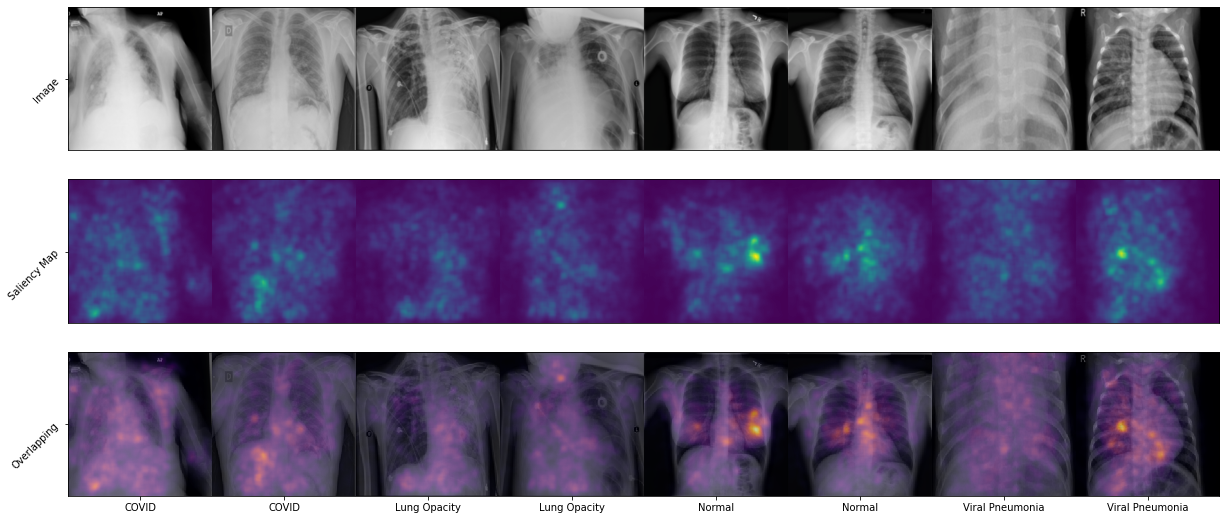

In [20]:
# Get the model.
# Model path
modelPath = 'models/raw(bf).pth'
# Load model values from the bilateral filter model.
pretrainedData = torch.load(modelPath)

# Get a predefined model from pytorch, without the pretrained parameters.
net = models.resnet34()
# Get the input size of the las layer of the model.
llInputSize = net.fc.in_features
# Modify the last layer of the model, to classify the amount of required classes.
net.fc = nn.Linear(llInputSize, config[outputSize])
# Load state
net.load_state_dict(pretrainedData[_model])

# Load the model to the selected device.
net.to(device)

# Set the model on Eval Mode
net.eval()

# Get random images per class.
amountPerClass = 2
images = getRandomImages(amountPerClass)

# Get list of images an saliency maps.
imageList, saliencyList = getSaliencyImageList(images, net)

viewHeatMap(imageList, saliencyList, amountPerClass)